In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Dataset_CLAHE.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Dataset_CLAHE/clahe_train/fire/aug_27_2734611.jpg  
  inflating: Dataset_CLAHE/clahe_train/fire/aug_27_9527230.jpg  
  inflating: Dataset_CLAHE/clahe_train/fire/aug_270_1630496.jpg  
  inflating: Dataset_CLAHE/clahe_train/fire/aug_270_8612991.jpg  
  inflating: Dataset_CLAHE/clahe_train/fire/aug_271_1315074.jpg  
  inflating: Dataset_CLAHE/clahe_train/fire/aug_271_5521205.jpg  
  inflating: Dataset_CLAHE/clahe_train/fire/aug_272_7883685.jpg  
  inflating: Dataset_CLAHE/clahe_train/fire/aug_272_8703720.jpg  
  inflating: Dataset_CLAHE/clahe_train/fire/aug_273_3447912.jpg  
  inflating: Dataset_CLAHE/clahe_train/fire/aug_273_4962161.jpg  
  inflating: Dataset_CLAHE/clahe_train/fire/aug_275_7860442.jpg  
  inflating: Dataset_CLAHE/clahe_train/fire/aug_276_3118356.jpg  
  inflating: Dataset_CLAHE/clahe_train/fire/aug_276_6912438.jpg  
  inflating: Dataset_CLAHE/clahe_train/fire/aug_276_6951373.jpg  
  inflating: Dataset_CLAHE/

In [ ]:
import matplotlib.pyplot as plt
import numpy
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np

In [ ]:
img_height, img_width = 224,224
batchsize = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/Dataset_CLAHE/clahe_train",
                                                               label_mode = "categorical",
                                                               image_size = (img_height, img_width),
                                                               batch_size = batchsize
                                                              )

Found 4804 files belonging to 3 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/Dataset_CLAHE/clahe_val",
                                                               label_mode = "categorical",
                                                               image_size = (img_height, img_width),
                                                               batch_size = batchsize
                                                              )

Found 601 files belonging to 3 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/Dataset_CLAHE/clahe_test",
                                                               label_mode = "categorical",
                                                               image_size = (img_height, img_width),
                                                               batch_size = batchsize
                                                              )

Found 601 files belonging to 3 classes.


In [ ]:
class_names = val_ds.class_names
print(class_names)
num_classes = len(class_names)

['fire', 'nofire', 'smoke']


### Visualizing the distribution

In [ ]:
# Initialize a dictionary to store class counts
class_counts = {class_idx: 0 for class_idx in range(num_classes)}

# Iterate through the dataset to count examples in each category
for images, labels in train_ds:
    # Convert one-hot encoded labels to class indices
    class_indices = tf.argmax(labels, axis=1).numpy()

    # Update class counts
    for class_idx in class_indices:
        class_counts[class_idx] += 1

In [ ]:
class_counts

{0: 1595, 1: 1604, 2: 1605}

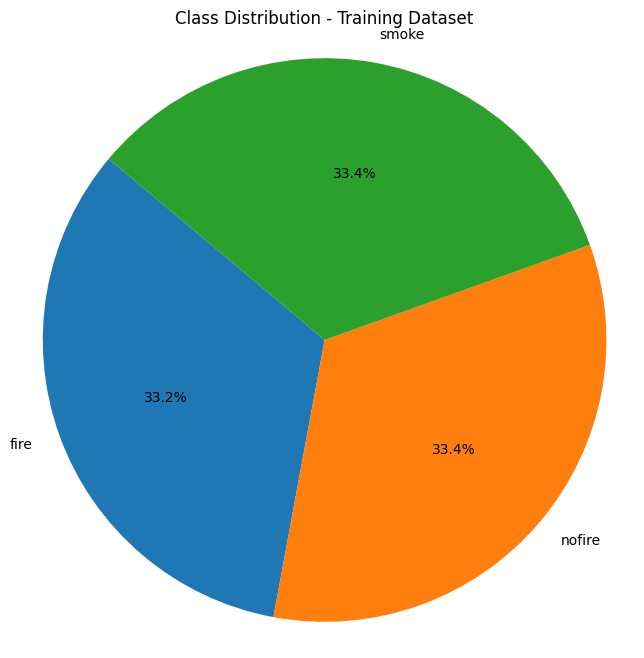

In [ ]:
import matplotlib.pyplot as plt



# Class counts (use the counts obtained from the previous code)
class_counts = list(class_counts.values())

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution - Training Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()



In [ ]:
# For validation dataset...

# Initialize a dictionary to store class counts
class_counts = {class_idx: 0 for class_idx in range(num_classes)}

# Iterate through the dataset to count examples in each category
for images, labels in val_ds:
    # Convert one-hot encoded labels to class indices
    class_indices = tf.argmax(labels, axis=1).numpy()

    # Update class counts
    for class_idx in class_indices:
        class_counts[class_idx] += 1

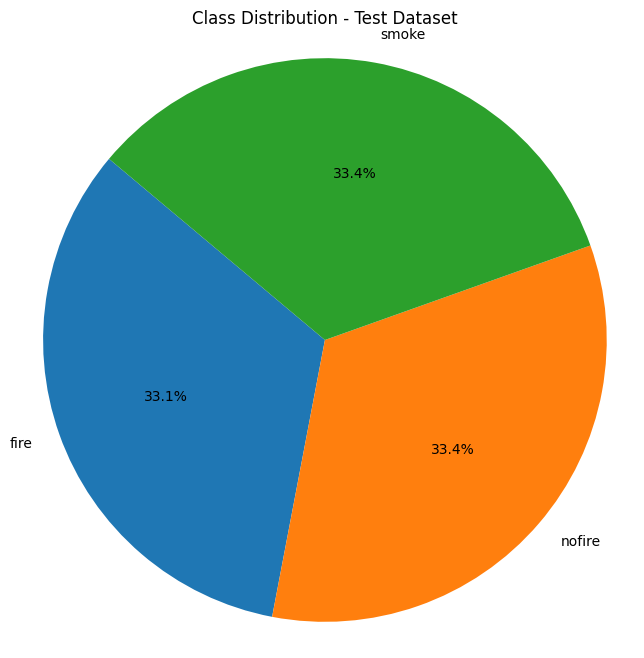

In [ ]:
import matplotlib.pyplot as plt



# Class counts (use the counts obtained from the previous code)
class_counts = list(class_counts.values())

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution - Test Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()




# DataSet Preparation

In [ ]:
# Define the input shape
input_shape = (224, 224, 3)  # Adjust the dimensions according to your image size

# Define the batch size and number of epochs
batch_size = 32
epochs = 30
img_height, img_width = 224,224

ImageDataGenerator

In [ ]:
# Create an ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.25
)

Training data


In [ ]:
train_generator = datagen.flow_from_directory("/content/Dataset_CLAHE/clahe_train",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              )

Found 4804 images belonging to 3 classes.


In [ ]:
val_generator = datagen.flow_from_directory( "/content/Dataset_CLAHE/clahe_val",
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                        )

Found 601 images belonging to 3 classes.


Testing data generator

In [ ]:
test_generator = datagen.flow_from_directory("/content/Dataset_CLAHE/clahe_test",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False
                                          )

Found 601 images belonging to 3 classes.


## Model Creation for Transfer Learning


In [ ]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import ResNet50
import h5py

In [ ]:
pretrained_model = tf.keras.applications.ResNet50(include_top = False,
                                                  input_shape = (224,224,3),
                                                  pooling = 'avg',
                                                  classes = 3,
                                                  weights = 'imagenet'
                                                 )


94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in pretrained_model.layers:
    layer.trainable = False

# Custom Layers
x = pretrained_model.output
x = Dense(512,activation = 'relu')(x)
predictions = Dense(3, activation = 'softmax')(x)

ResNet50_model = Model(inputs=pretrained_model.input, outputs=predictions)

In [ ]:
ResNet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

Model Compile

In [ ]:
ResNet50_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


Early Stopping

In [ ]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=3)

Model Training

In [ ]:
# Train the model
history = ResNet50_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)


Epoch 1/30
150/150 [==============================] - 39s 159ms/step - loss: 1.0567 - accuracy: 0.4763 - val_loss: 0.8737 - val_accuracy: 0.5990
Epoch 2/30
150/150 [==============================] - 23s 150ms/step - loss: 0.9536 - accuracy: 0.5383 - val_loss: 0.8865 - val_accuracy: 0.5451
Epoch 3/30
150/150 [==============================] - 23s 153ms/step - loss: 0.9148 - accuracy: 0.5564 - val_loss: 0.8410 - val_accuracy: 0.5955
Epoch 4/30
150/150 [==============================] - 22s 149ms/step - loss: 0.9043 - accuracy: 0.5666 - val_loss: 0.8951 - val_accuracy: 0.5972
Epoch 5/30
150/150 [==============================] - 23s 150ms/step - loss: 0.8552 - accuracy: 0.6136 - val_loss: 0.8154 - val_accuracy: 0.6111
Epoch 6/30
150/150 [==============================] - 23s 150ms/step - loss: 0.8296 - accuracy: 0.6213 - val_loss: 0.7719 - val_accuracy: 0.6736
Epoch 7/30
150/150 [==============================] - 22s 149ms/step - loss: 0.8332 - accuracy: 0.6137 - val_loss: 0.8658 - val_ac

Evaluation of Model

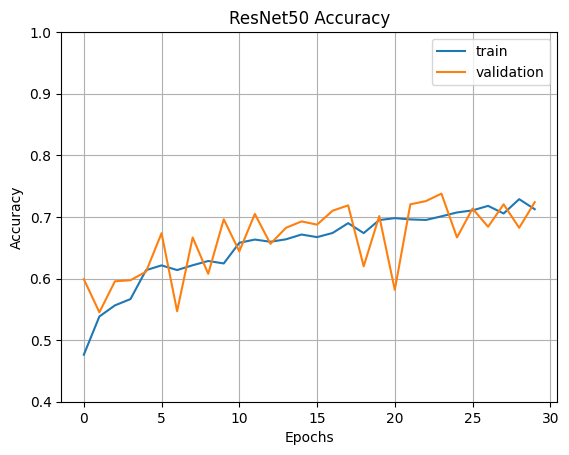

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin = 0.4, ymax = 1)
plt.grid()
plt.title('ResNet50 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

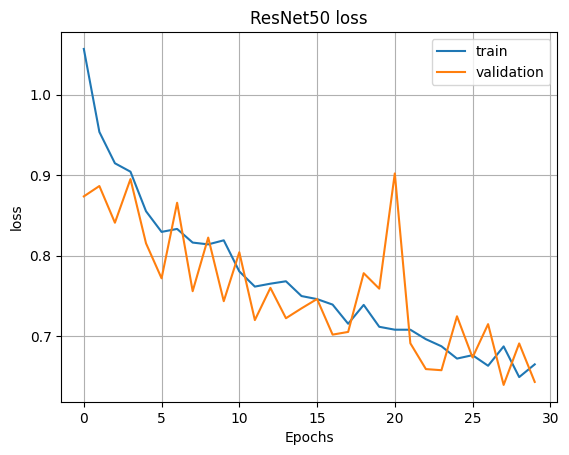

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.axis(ymin = 0.4, ymax = 1)
plt.grid()
plt.title('ResNet50 loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
test_generator = datagen.flow_from_directory("/content/Dataset_CLAHE/clahe_test",
                                                               class_mode = "categorical",
                                                               batch_size = batchsize
                                                              )

Found 601 images belonging to 3 classes.


In [ ]:
# Create an ImageDataGenerator without data augmentation for the test set
test_val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Generate batches of data from the test directory
test_generator = test_val_datagen.flow_from_directory(
    "/content/Dataset_CLAHE/clahe_test",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False )

# Evaluate the model on the test set
test_loss, test_accuracy = ResNet50_model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Found 601 images belonging to 3 classes.
18/18 [==============================] - 4s 205ms/step - loss: 0.6240 - accuracy: 0.7344
Test Loss: 0.6240217685699463
Test Accuracy: 0.734375


In [ ]:
# Make predictions on the test set
predictions = ResNet50_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

19/19 [==============================] - 6s 240ms/step


In [ ]:
# Get the true labels
true_labels = test_generator.classes

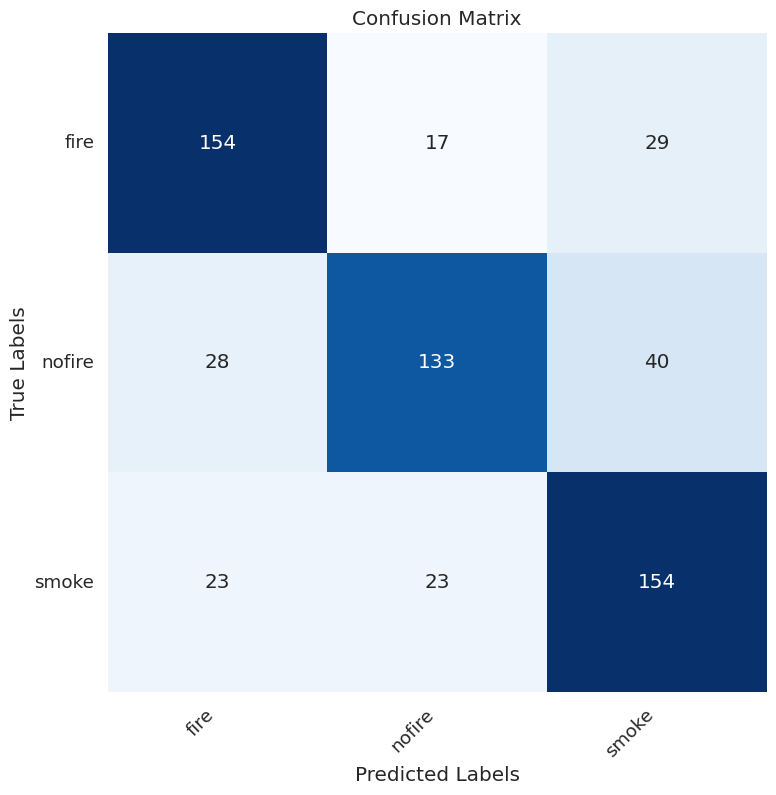

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get the class names and number of classes
class_names = list(test_generator.class_indices.keys())
num_classes = len(class_names)

# Create a figure and axes
plt.figure(figsize=(8, 15))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

# Add labels, title, and ticks
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(num_classes) + 0.5, class_names, rotation=45, ha='right')
plt.yticks(np.arange(num_classes) + 0.5, class_names, rotation=0)

# Show the plot
plt.tight_layout()



plt.show()

In [ ]:

# Print the classification report
class_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

        fire       0.75      0.77      0.76       200
      nofire       0.77      0.66      0.71       201
       smoke       0.69      0.77      0.73       200

    accuracy                           0.73       601
   macro avg       0.74      0.73      0.73       601
weighted avg       0.74      0.73      0.73       601



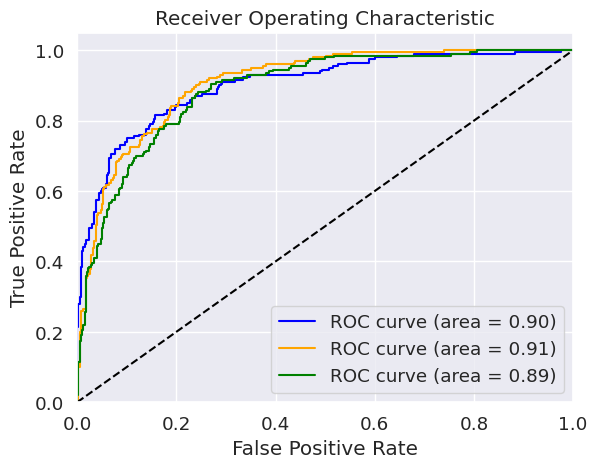

In [ ]:
# Compute the ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure()
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown','c',
          'm', 'y', 'k', '#FF00FF', '#008080','#800000', '#808080',
          '#FFC0CB',]
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


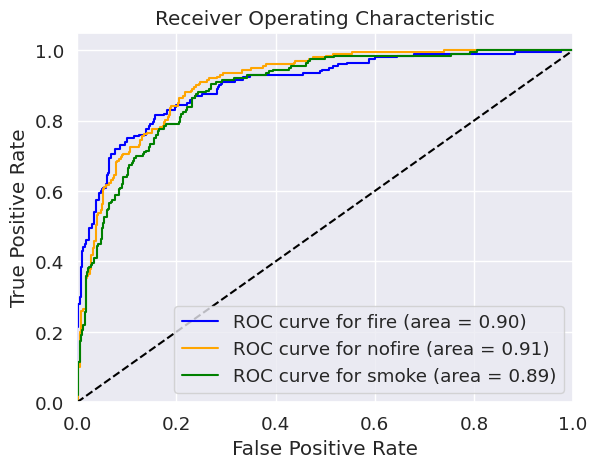

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Load the class names
class_names = ["fire","nofire","smoke"]

# Compute the ROC curve and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure()
colors = ['blue', 'orange', 'green']

for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], color=colors[i], label='ROC curve for {} (area = {:.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


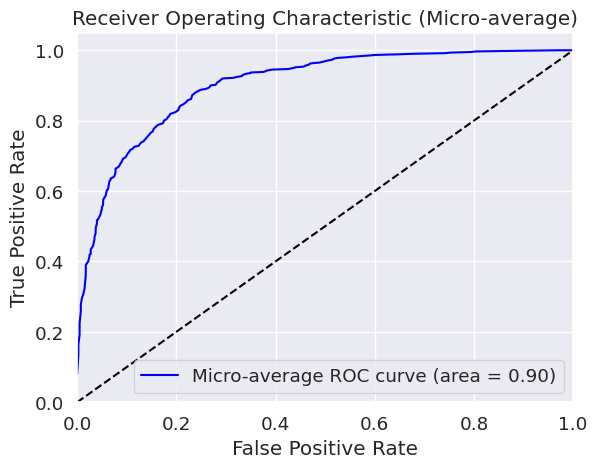

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Load the class names
class_names = ["fire","nofire","smoke"]

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= len(class_names)
roc_auc["micro"] = auc(all_fpr, mean_tpr)

# Plot the ROC curve for the micro-average
plt.figure()
plt.plot(all_fpr, mean_tpr, color='blue', label='Micro-average ROC curve (area = {:.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Micro-average)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
ResNet50_model.save("Forest_fire_on_augmented_data_using_resnet50.keras")